# Gender Prediction

Importing Libraries needed to run spark, SQL commands, pandas, timestamps, regressions, pipelines, datetime conversion
plotting, numpy, crossvalidating, typecasting and classification models such as Logistic Regrssion, Random Forest
Classification and Gradient Boosted Trees

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import sys
import os
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import to_timestamp
import time
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, Pipeline

import datetime
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second
from pyspark.mllib.stat import Statistics
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.appName('data-cleaning').\
                        config("spark.executor.instances", '3').\
                        config("spark.executor.memory", '40g').\
                        config('spark.executor.cores', '5').\
                        config('spark.cores.max', '5').appName('gender_predict').\
                        getOrCreate()

sqlContext = SQLContext(spark.sparkContext)

from pyspark.ml import Pipeline
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator

from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.mllib.util import MLUtils
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [2]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.lines as mlines

Calling the csv file exported after cleaning the data, keeping headers intact

In [3]:
data = spark.read.format('csv').option('header', 'true').load('../modeled_data/spark_data3.csv')

Viewing the first five rows of the data

In [4]:
data.limit(5).toPandas()

,device_id,label_id,app_id,event_id,gender,age,group,timestamp,longitude,latitude,...,town,country,year,month,day,hour,minute,seconds,time_of_day,age_group
0,-6754902882206380496,704,-145658454112781034,35963,M,33,M32-38,2016-05-01 08:55:39,106.56,29.53,...,Chongqing,China,2016,5,1,8,55,39,morning,26-35
1,5416618857406916680,209,2460654806659045896,1773101,M,30,M29-31,2016-05-05 12:08:32,106.56,29.53,...,Chongqing,China,2016,5,5,12,8,32,morning,26-35
2,5416618857406916680,209,2460654806659045896,1773101,M,30,M29-31,2016-05-05 12:08:32,106.56,29.53,...,Chongqing,China,2016,5,5,12,8,32,morning,26-35
3,1698428484639625968,303,-145658454112781034,37174,M,27,M27-28,2016-05-06 07:57:01,116.21,34.26,...,Henan,China,2016,5,6,7,57,1,morning,26-35
4,1698428484639625968,303,-145658454112781034,37174,M,27,M27-28,2016-05-06 07:57:01,116.21,34.26,...,Henan,China,2016,5,6,7,57,1,morning,26-35


Viewing the distribution of the Gender Column

In [5]:
data.groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|25819|
|     M|51338|
+------+-----+



Splitting the data into training, testing and validation randomly in the order of 70% training, 20% testing and 10% validation

In [6]:
training, test,validation = data.randomSplit([0.7, 0.2,0.1], )

In [7]:
# Print Schema
data.printSchema()

root
 |-- device_id: string (nullable = true)
 |-- label_id: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- event_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- group: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- is_installed: string (nullable = true)
 |-- is_active: string (nullable = true)
 |-- category: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- phone_brand: string (nullable = true)
 |-- location: string (nullable = true)
 |-- town: string (nullable = true)
 |-- country: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- minute: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- time_of_day: string (nullable = true)
 |-- age_grou

Typecasting the columns in training, testing and validation to float, integer and string as required

In [8]:
float_columns = ['device_id', 'app_id', 'label_id', 'event_id', 'longitude', 'latitude']
int_columns = ['is_active', 'age', 'is_installed', 'day', 'hour', 'minute', 'seconds']
string_columns = ['gender', 'phone_brand', 'device_model', 'town', 'country', 'category', 'time_of_day', 'age_group']

training = training.select(*(col(c).cast("float").alias(c) for c in float_columns), \
                                                 *(col(c).cast("int").alias(c) for c in int_columns), \
                                                 *(col(c).alias(c) for c in string_columns))

validation = validation.select(*(col(c).cast("float").alias(c) for c in float_columns), \
                                                 *(col(c).cast("int").alias(c) for c in int_columns), \
                                                 *(col(c).alias(c) for c in string_columns))

test = test.select(*(col(c).cast("float").alias(c) for c in float_columns), \
                                                 *(col(c).cast("int").alias(c) for c in int_columns), \
                                                 *(col(c).alias(c) for c in string_columns))

## Correlation Matrix

In [10]:
#Correlation Matrix to get feature correlation with Gender
indexer = feature.StringIndexer(inputCol="gender", outputCol="gender_label")
category = feature.StringIndexer(inputCol='category', outputCol='category_encoded')
brand = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded')
age_group_indexer = feature.StringIndexer(inputCol='age_group', outputCol='age_group_encoded',handleInvalid='skip')
is_active = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded')
device_model = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded')
town_model = feature.StringIndexer(inputCol='town', outputCol='town_encoded')
country_model = feature.StringIndexer(inputCol='country', outputCol='country_encoded')
time_of_day_indexer = feature.StringIndexer(inputCol='time_of_day', outputCol='time_of_day_encoded',handleInvalid='skip')


correlation_pipeline = Pipeline(stages=[indexer, category, brand, age_group_indexer, time_of_day_indexer, is_active, device_model, town_model, country_model])
encoded_data = correlation_pipeline.fit(training).transform(training)

encoded_data = encoded_data['gender_label','device_id', 'app_id', 'category_encoded', 'phone_brand_encoded', 'age_group_encoded', 'is_active_encoded', 'device_model_encoded',\
                           'town_encoded', 'country_encoded', 'label_id', 'event_id', 'time_of_day_encoded', 'longitude', 'latitude', 'day', 'hour', 'minute']
col_names = encoded_data.columns
features = encoded_data.rdd.map(lambda row: row[0:])
features
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)

corr_df.columns = col_names

corr = corr_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,gender_label,device_id,app_id,category_encoded,phone_brand_encoded,age_group_encoded,is_active_encoded,device_model_encoded,town_encoded,country_encoded,label_id,event_id,time_of_day_encoded,longitude,latitude,day,hour,minute
gender_label,1,0.00780854,-0.0522519,-0.158364,-0.144381,0.176781,0.102372,-0.121318,-0.0496257,0.0392132,0.131302,-0.0632388,-0.109906,-0.0554346,-0.0533581,-0.0182932,-0.0696664,-0.103061
device_id,0.00780854,1,-0.0284569,-0.00162754,-0.164137,-0.0240205,-0.0660473,-0.162107,-0.161433,0.0350338,-0.0437487,-0.050579,-0.0530851,-0.037834,-0.0834485,-0.0385067,-0.0194378,-0.0594579
app_id,-0.0522519,-0.0284569,1,-0.0915009,-0.0925834,-0.0827806,0.132981,-0.0878002,-0.0947283,-0.00932563,-0.071396,-0.0626321,-0.082082,-0.0185092,-0.0578306,-0.0483735,-0.0447598,-0.0703587
category_encoded,-0.158364,-0.00162754,-0.0915009,1,-0.0368598,-0.0501859,-0.050179,-0.0603867,-0.0101039,-0.0126042,-0.765276,-0.0298732,0.00217097,0.0100557,0.0216451,-0.0374818,-0.0140043,-0.00907074
phone_brand_encoded,-0.144381,-0.164137,-0.0925834,-0.0368598,1,-0.00721117,-0.000627549,0.810129,-0.0452153,0.178202,-0.0368885,-0.0692991,-0.0590067,-0.270278,-0.27998,-0.119684,-0.0906899,-0.0791615
age_group_encoded,0.176781,-0.0240205,-0.0827806,-0.0501859,-0.00721117,1,0.04254,-0.0258367,-0.0794104,0.0554934,-0.012716,-0.063441,-0.0776494,-0.0862665,-0.0828717,-0.0923373,-0.074995,-0.0892577
is_active_encoded,0.102372,-0.0660473,0.132981,-0.050179,-0.000627549,0.04254,1,0.0144407,-0.0735444,0.0490355,-0.119084,-0.099872,0.034067,-0.0912688,-0.1058,-0.0412926,0.038629,-0.165462
device_model_encoded,-0.121318,-0.162107,-0.0878002,-0.0603867,0.810129,-0.0258367,0.0144407,1,0.00549143,0.101159,-0.0334942,-0.066702,-0.0632751,-0.185983,-0.191671,-0.123206,-0.0965899,-0.122379
town_encoded,-0.0496257,-0.161433,-0.0947283,-0.0101039,-0.0452153,-0.0794104,-0.0735444,0.00549143,1,-0.258553,-0.0455582,-0.0711253,-0.0609948,0.229182,0.455768,-0.0621958,-0.110195,-0.0853701
country_encoded,0.0392132,0.0350338,-0.00932563,-0.0126042,0.178202,0.0554934,0.0490355,0.101159,-0.258553,1,0.025498,0.0151455,-0.0145195,-0.960086,-0.866572,0.0622678,0.0429787,-0.0459326


String indexing the string columns and calling string encoded columns into vector assembler along with numerical columns
then initializing standard scaler and pulling the indexers along with the vector assembler and standard scaler into the pipeline, also initializing a binary classification evaluator

In [11]:
#Pipeline of Feature Engineering
gender_indexer = feature.StringIndexer(inputCol="gender", outputCol="label",handleInvalid='skip')
category_indexer = feature.StringIndexer(inputCol='category', outputCol='category_encoded',handleInvalid='skip')
phone_brand_indexer = feature.StringIndexer(inputCol='phone_brand', outputCol='phone_brand_encoded',handleInvalid='skip')
is_active_indexer = feature.StringIndexer(inputCol='is_active', outputCol='is_active_encoded',handleInvalid='skip')
device_model_indexer = feature.StringIndexer(inputCol='device_model', outputCol='device_model_encoded',handleInvalid='skip')
town_indexer = feature.StringIndexer(inputCol='town', outputCol='town_encoded',handleInvalid='skip')
country_indexer = feature.StringIndexer(inputCol='country', outputCol='country_encoded',handleInvalid='skip')
time_of_day_indexer = feature.StringIndexer(inputCol='time_of_day', outputCol='time_of_day_encoded',handleInvalid='skip')
age_group_indexer = feature.StringIndexer(inputCol='age_group', outputCol='age_group_encoded',handleInvalid='skip')


vector_assembler = feature.VectorAssembler(inputCols=['app_id', 'label_id', 'event_id', 'is_active',\
                                                      'device_model_encoded', 'phone_brand_encoded', 'town_encoded', 'country_encoded',\
                                                      'time_of_day_encoded', 'age_group_encoded', 'category_encoded'],
                                        outputCol='features')
sc = feature.StandardScaler(inputCol='features',outputCol='sfeatures')

evaluator = BinaryClassificationEvaluator(labelCol='label')

pipe_prep=Pipeline(stages=[gender_indexer, category_indexer,phone_brand_indexer, is_active_indexer, device_model_indexer,\
                           town_indexer, country_indexer, time_of_day_indexer, age_group_indexer, \
                           vector_assembler, sc])

Defining an evaluation function which creates a readable result for us to interpret, this function displays the Area under the ROC curve, the Precision and recall of the overall model along with precision and recall of both genders, it also displays the area under the Precision and Recall curve and additionally the confusion matrix which displays the true and false positives and negatives

In [12]:
def evaluate(predictionAndLabels):
    log = {}

    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)    
    print("Area under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label, 
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'], 
                    log[label]['recall'], log[label]['F1 Measure']))

    return log

## Logistic regression to predict gender

In [19]:
# logistic with default or no parameters
logistic = classification.LogisticRegression(labelCol='label', featuresCol='sfeatures')
lr_pipe = Pipeline(stages=[pipe_prep, logistic]).fit(training)
evaluate(lr_pipe.transform(test))

Area under ROC = 0.613564
Area under PR = 0.434467
[[9944.  346.]
 [4928.  364.]]
[Overall]	precision = 0.6615325375433192 | recall = 0.6615325375433192 | F1 Measure = 0.6615325375433192
[Class 0.0]	precision = 0.6686390532544378 | recall = 0.9663751214771623 | F1 Measure = 0.7903982195373975
[Class 1.0]	precision = 0.5126760563380282 | recall = 0.06878306878306878 | F1 Measure = 0.12129290236587802


{'AUROC': '0.613564',
 'AUPR': '0.434467',
 'precision': '0.6615325375433192',
 'recall': '0.6615325375433192',
 'F1 Measure': '0.6615325375433192',
 0.0: {'precision': '0.6686390532544378',
  'recall': '0.9663751214771623',
  'F1 Measure': '0.7903982195373975'},
 1.0: {'precision': '0.5126760563380282',
  'recall': '0.06878306878306878',
  'F1 Measure': '0.12129290236587802'}}

In [ ]:
# Logistic Regression Cross Validation
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

lr_pipe = Pipeline(stages=[pipe_prep, logistic])

lr_param = ParamGridBuilder() \
    .addGrid(logistic.elasticNetParam, [0.0, 0.1, 0.5, 0.8, 1]) \
    .addGrid(logistic.regParam, [0, 0.01, 0.05, 0.1, 0.5, 1]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')
#evaluator = RegressionEvaluator(labelCol="town_encoded", predictionCol="prediction", metricName="r2")
#evaluator = MulticlassClassificationEvaluator(labelCol = 'town_encoded', predictionCol='prediction', metricName = 'accuracy')
crossval = CrossValidator(estimator=lr_pipe,
                         estimatorParamMaps=lr_param,
                         evaluator=evaluator,
                         numFolds=5)

cvmodel = crossval.fit(validation)
cvmodel.bestModel.stages[-1].extractParamMap()

In [42]:
# Best Parameters on Validation Set
logistic1 = classification.LogisticRegression(labelCol='label', featuresCol='sfeatures',maxIter=300,regParam=0.1)
lr_pipe1 = Pipeline(stages=[pipe_prep, logistic1]).fit(training)
evaluate(lr_pipe1.transform(validation))

Area under ROC = 0.606309
Area under PR = 0.425389
[[5084.   33.]
 [2495.   63.]]
[Overall]	precision = 0.6706188925081433 | recall = 0.6706188925081433 | F1 Measure = 0.6706188925081433
[Class 0.0]	precision = 0.6708008972159916 | recall = 0.9935509087355873 | F1 Measure = 0.8008821676118463
[Class 1.0]	precision = 0.65625 | recall = 0.024628616106333073 | F1 Measure = 0.04747550866616428


{'AUROC': '0.606309',
 'AUPR': '0.425389',
 'precision': '0.6706188925081433',
 'recall': '0.6706188925081433',
 'F1 Measure': '0.6706188925081433',
 0.0: {'precision': '0.6708008972159916',
  'recall': '0.9935509087355873',
  'F1 Measure': '0.8008821676118463'},
 1.0: {'precision': '0.65625',
  'recall': '0.024628616106333073',
  'F1 Measure': '0.04747550866616428'}}

In [20]:
# Best Parameters on Test Set
logistic1 = classification.LogisticRegression(labelCol='label', featuresCol='sfeatures',maxIter=300,regParam=0.1)
lr_pipe1 = Pipeline(stages=[pipe_prep, logistic1]).fit(training)
evaluate(lr_pipe1.transform(test))

Area under ROC = 0.612713
Area under PR = 0.433956
[[10207.    83.]
 [ 5205.    87.]]
[Overall]	precision = 0.6606340649467334 | recall = 0.6606340649467334 | F1 Measure = 0.6606340649467334
[Class 0.0]	precision = 0.6622761484557488 | recall = 0.9919339164237123 | F1 Measure = 0.7942572562446503
[Class 1.0]	precision = 0.5117647058823529 | recall = 0.016439909297052153 | F1 Measure = 0.031856462834126686


{'AUROC': '0.612713',
 'AUPR': '0.433956',
 'precision': '0.6606340649467334',
 'recall': '0.6606340649467334',
 'F1 Measure': '0.6606340649467334',
 0.0: {'precision': '0.6622761484557488',
  'recall': '0.9919339164237123',
  'F1 Measure': '0.7942572562446503'},
 1.0: {'precision': '0.5117647058823529',
  'recall': '0.016439909297052153',
  'F1 Measure': '0.031856462834126686'}}

Viewing Absolute loadings to understand feature importance of the default logistic regression model

In [21]:
# LR Loadings
lr_model=lr_pipe.stages[-1]
pd.DataFrame(list(zip(['app_id', 'label_id', 'event_id', 'is_active','device_model_encoded', 'phone_brand_encoded', 'town_encoded', 'country_encoded','time_of_day_encoded', 'age_group_encoded', 'category_encoded'],
                     lr_model.coefficients.toArray())),
            columns = ['column', 'weight']).sort_values('weight', ascending=False)

,column,weight
9,age_group_encoded,0.254392
3,is_active,0.202539
1,label_id,0.173679
6,town_encoded,0.059305
7,country_encoded,0.045121
2,event_id,0.018787
4,device_model_encoded,0.013772
0,app_id,0.004523
10,category_encoded,-0.020079
8,time_of_day_encoded,-0.037139


In [22]:
# Save the Best Model after cross validation - 
lr_pipe.write().overwrite().save("../saved_models/logistic")

## Random forest to predict Gender

In [28]:
# Random Forest Gender
rf=classification.RandomForestClassifier(labelCol='label', featuresCol='sfeatures')
rf_pipe=Pipeline(stages=[pipe_prep,rf]).fit(training)
evaluator = BinaryClassificationEvaluator(labelCol = 'label', metricName ='areaUnderROC')
resultrf4=evaluator.evaluate(rf_pipe.transform(validation))
resultrf4

0.7545706847569833

Using evaluation function to view performance of Random Forest Classification Model

In [29]:
evaluate(rf_pipe.transform(test))

Area under ROC = 0.760207
Area under PR = 0.614624
[[9882.  430.]
 [4069. 1101.]]
[Overall]	precision = 0.7094044697067562 | recall = 0.7094044697067562 | F1 Measure = 0.7094044697067562
[Class 0.0]	precision = 0.7083363199770626 | recall = 0.9583010085337471 | F1 Measure = 0.814573630631002
[Class 1.0]	precision = 0.7191378184193338 | recall = 0.21295938104448742 | F1 Measure = 0.32860767049694073


{'AUROC': '0.760207',
 'AUPR': '0.614624',
 'precision': '0.7094044697067562',
 'recall': '0.7094044697067562',
 'F1 Measure': '0.7094044697067562',
 0.0: {'precision': '0.7083363199770626',
  'recall': '0.9583010085337471',
  'F1 Measure': '0.814573630631002'},
 1.0: {'precision': '0.7191378184193338',
  'recall': '0.21295938104448742',
  'F1 Measure': '0.32860767049694073'}}

In [34]:
## Random Forest Cross Validation
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

rf_pipe=Pipeline(stages=[pipe_prep,rf])

rfParam = ParamGridBuilder() \
.addGrid(rf.maxDepth, [5, 10, 15, 20, 25]) \
.addGrid(rf.maxBins, [10, 20, 30, 40]) \
.addGrid(rf.numTrees, [30, 40, 50]) \
.addGrid(rf.impurity, ["gini"]) \
.build()
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')
crossval = CrossValidator(estimator=rf_pipe,
                         estimatorParamMaps=rfParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(validation)
cvmodel.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_eb87306b088a', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_eb87306b088a', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_eb87306b088a', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_eb87306b088a', name='featuresCol', doc='features column name'): 'sfeatures',
 Param(parent='RandomForestClassifier_eb87306b088a',

Running Random forest classifier and fitting it on training data with tuned parameters max depth 10 and number of trees 50

In [23]:
# RF with best params
rf1=classification.RandomForestClassifier(labelCol='label', featuresCol='sfeatures',maxDepth=15, maxBins=30, numTrees=40)

rf_pipe1=Pipeline(stages=[pipe_prep,rf1]).fit(training)
evaluate(rf_pipe1.transform(test))

Area under ROC = 0.949800
Area under PR = 0.916629
[[9877.  413.]
 [1483. 3809.]]
[Overall]	precision = 0.8783211397766654 | recall = 0.8783211397766654 | F1 Measure = 0.8783211397766654
[Class 0.0]	precision = 0.8694542253521127 | recall = 0.9598639455782313 | F1 Measure = 0.9124249422632794
[Class 1.0]	precision = 0.9021790620558977 | recall = 0.7197656840513983 | F1 Measure = 0.8007147361782636


{'AUROC': '0.949800',
 'AUPR': '0.916629',
 'precision': '0.8783211397766654',
 'recall': '0.8783211397766654',
 'F1 Measure': '0.8783211397766654',
 0.0: {'precision': '0.8694542253521127',
  'recall': '0.9598639455782313',
  'F1 Measure': '0.9124249422632794'},
 1.0: {'precision': '0.9021790620558977',
  'recall': '0.7197656840513983',
  'F1 Measure': '0.8007147361782636'}}

In [24]:
# Matrix of Gender Classification 
y_actu = pd.Series(rf_pipe1.transform(test).select('label').collect(), name='Actual')
y_pred = pd.Series(rf_pipe1.transform(test).select('prediction').collect(), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
df_confusion

Predicted,"(0.0,)","(1.0,)"
Actual,,
"(0.0,)",9877,413
"(1.0,)",1483,3809


In [25]:
# Feature Importance
columns = ['app_id', 'label_id', 'event_id', 'is_active',\
                                                      'device_model_encoded', 'phone_brand_encoded', 'town_encoded', 'country_encoded',\
                                                      'time_of_day_encoded', 'age_group_encoded', 'category_encoded']
pd.DataFrame(list(zip(columns, rf_pipe1.stages[-1].featureImportances.toArray())),
            columns = ['column', 'importance']).sort_values('importance', ascending=False)

,column,importance
1,label_id,0.256229
6,town_encoded,0.134066
4,device_model_encoded,0.131106
0,app_id,0.116546
2,event_id,0.095818
5,phone_brand_encoded,0.079453
9,age_group_encoded,0.066851
10,category_encoded,0.050658
8,time_of_day_encoded,0.040277
3,is_active,0.020915


In [26]:
# Save the Best Model after cross validation - 
rf_pipe1.write().overwrite().save("../saved_models/random_forest")

## Gradient Boost to predict Gender

In [27]:
#GBT with default

gbt = classification.GBTClassifier(labelCol='label', featuresCol='sfeatures')
gbt_pipe=Pipeline(stages=[pipe_prep,gbt]).fit(training)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')
resultrf4=evaluator.evaluate(gbt_pipe.transform(test))
resultrf4

0.829566907747875

Evaluating Gradient Boosted Trees Classifier Crossvalidation

In [ ]:
# GBT Cross Validation

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

gbt_pipe = Pipeline(stages=[pipe_prep, gbt])

gbtParam = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [4, 6, 8, 10])
             .addGrid(gbt.maxBins, [5, 10, 20])
             .addGrid(gbt.maxIter, [2])
             .build())

evaluator = BinaryClassificationEvaluator(labelCol="gender_label", metricName='areaUnderROC')
crossval = CrossValidator(estimator=gbt_pipe,
                         estimatorParamMaps=gbtParam,
                         evaluator=evaluator,
                         numFolds=3)

cvmodel = crossval.fit(validation)
cvmodel.bestModel.stages[-1].extractParamMap()

In [28]:
# GBT with Best Params
gbt = classification.GBTClassifier(labelCol='label', featuresCol='sfeatures', maxDepth=15, maxBins=30, lossType = 'logistic', maxIter=2)
gbt_pipe=Pipeline(stages=[pipe_prep,gbt]).fit(training)

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName='areaUnderROC')

resultrf4=evaluator.evaluate(gbt_pipe.transform(test))

resultrf4
evaluate(gbt_pipe.transform(test))

Area under ROC = 0.884971
Area under PR = 0.825646
[[9601.  689.]
 [1737. 3555.]]
[Overall]	precision = 0.8443075343344885 | recall = 0.8443075343344885 | F1 Measure = 0.8443075343344885
[Class 0.0]	precision = 0.8467983771388252 | recall = 0.933041788143829 | F1 Measure = 0.8878305899759571
[Class 1.0]	precision = 0.8376531573986805 | recall = 0.6717687074829932 | F1 Measure = 0.7455956375838927


{'AUROC': '0.884971',
 'AUPR': '0.825646',
 'precision': '0.8443075343344885',
 'recall': '0.8443075343344885',
 'F1 Measure': '0.8443075343344885',
 0.0: {'precision': '0.8467983771388252',
  'recall': '0.933041788143829',
  'F1 Measure': '0.8878305899759571'},
 1.0: {'precision': '0.8376531573986805',
  'recall': '0.6717687074829932',
  'F1 Measure': '0.7455956375838927'}}

In [29]:
# Feature Importance
columns = ['app_id', 'label_id', 'event_id', 'is_active',\
                                                      'device_model_encoded', 'phone_brand_encoded', 'town_encoded', 'country_encoded',\
                                                      'time_of_day_encoded', 'age_group_encoded', 'category_encoded']
pd.DataFrame(list(zip(columns, gbt_pipe.stages[-1].featureImportances.toArray())),
            columns = ['column', 'importance']).sort_values('importance', ascending=False)

,column,importance
1,label_id,0.190378
4,device_model_encoded,0.149290
0,app_id,0.148330
6,town_encoded,0.144974
2,event_id,0.118502
5,phone_brand_encoded,0.074504
9,age_group_encoded,0.060930
8,time_of_day_encoded,0.042137
10,category_encoded,0.037857
3,is_active,0.024317


In [30]:
# Save the Best Model after cross validation - 
gbt_pipe.write().overwrite().save("../saved_models/GBT")

## ROC Curves for all Models

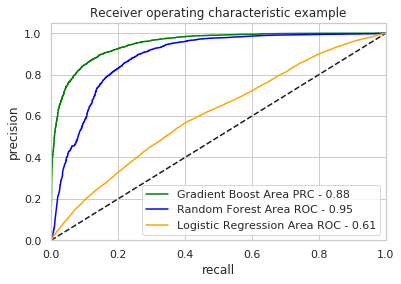

In [33]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.lines as mlines

# Random Forest
results = rf_pipe1.transform(test).select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list) 
metrics = metric(scoreAndLabels)
fpr1 = dict()
tpr1 = dict()
roc_auc = dict()
y_test1 = [i[1] for i in results_list]
y_score1 = [i[0] for i in results_list]
fpr1, tpr1, _ = roc_curve(y_test1, y_score1)


# Gradient Boost
results = gbt_pipe.transform(test).select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)
fpr2 = dict()
tpr2 = dict()
roc_auc = dict()
y_test2 = [i[1] for i in results_list]
y_score2 = [i[0] for i in results_list]
fpr2, tpr2, _ = roc_curve(y_test2, y_score2)


# Logistic Regression
trainingSummary = lr_pipe.stages[-1].summary
roc = trainingSummary.roc.toPandas()


%matplotlib inline
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Receiver operating characteristic example')

plot1= plt.plot(fpr1, tpr1, color='green')
plot2 = plt.plot(fpr2, tpr2, color='Blue')
plot3 = plt.plot(roc['FPR'],roc['TPR'], color='orange')

plot_lines = [plot1, plot2]
green_line = mlines.Line2D([], [], color='green', label='Gradient Boost Area PRC - 0.88')
blue_line = mlines.Line2D([], [], color='blue', label='Random Forest Area ROC - 0.95')
orange_line = mlines.Line2D([], [], color='orange', label='Logistic Regression Area ROC - 0.61')

plt.legend(handles=[green_line, blue_line, orange_line], loc=0)

plt.savefig('../plots/ROC.png', dpi=100)

plt.show()

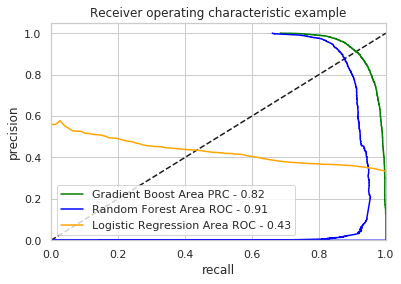

In [34]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.lines as mlines

# Random Forest
results = rf_pipe1.transform(test).select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list) 
metrics = metric(scoreAndLabels)
fpr1 = dict()
tpr1 = dict()
roc_auc = dict()
y_test1 = [i[1] for i in results_list]
y_score1 = [i[0] for i in results_list]
precision, recall, _ = precision_recall_curve(y_test1, y_score1)


# Gradient Boost
results = gbt_pipe.transform(test).select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = spark.sparkContext.parallelize(results_list)
fpr2 = dict()
tpr2 = dict()
roc_auc = dict()
y_test2 = [i[1] for i in results_list]
y_score2 = [i[0] for i in results_list]
precision2, recall2, _ = precision_recall_curve(y_test2, y_score2)


# Logistic Regression
trainingSummary = lr_pipe.stages[-1].summary
pr = trainingSummary.pr.toPandas()


%matplotlib inline
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Receiver operating characteristic example')

plot1= plt.plot(precision, recall, color='green')
plot2 = plt.plot(precision2, recall2, color='Blue')
plot3 = plt.plot(pr['recall'],pr['precision'], color='orange')

plot_lines = [plot1, plot2]
green_line = mlines.Line2D([], [], color='green', label='Gradient Boost Area PRC - 0.82')
blue_line = mlines.Line2D([], [], color='blue', label='Random Forest Area ROC - 0.91')
orange_line = mlines.Line2D([], [], color='orange', label='Logistic Regression Area ROC - 0.43')

plt.legend(handles=[green_line, blue_line, orange_line], loc=0)

plt.savefig('../plots/PRC.png', dpi=100)

plt.show()

In [13]:
spark.stop()